In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive

/content/drive


In [3]:
cd MyDrive

/content/drive/MyDrive


In [4]:
cd WeatherForecastingApp/

/content/drive/MyDrive/WeatherForecastingApp


In [5]:
cd notebooks

/content/drive/MyDrive/WeatherForecastingApp/notebooks


# Weather Forecasting App
In this notebook, we will define the pipeline for the final model, incorporating the modifications and insights derived from the data analysis conducted in the notebook 'Weather_Forecasting_Offline_Data_Analysis_and_Preprocessing'. The pipeline will also leverage the binary classifier selected based on the evaluation performed in the notebook 'Weather_Forecasting_Model_Selection'. Additionally, we will train and evaluate the model to ensure a certain level of performance.

In [6]:
!pip install feature_engine
!pip install "dask[dataframe]"
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.0
!pip install --upgrade threadpoolctl
!pip list | grep scikit

Found existing installation: scikit-learn 1.5.0
Uninstalling scikit-learn-1.5.0:
  Successfully uninstalled scikit-learn-1.5.0
  Using cached scikit_learn-1.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
scikit-image                       0.25.0
scikit-learn                       1.5.0


In [7]:
# function to create a requirements.txt file
def create_requirements_file():
    # content of the requirements.txt file
    requirements =
    feature_engine
    dask[dataframe]
    scikit-learn==1.4.0
    threadpoolctl

    # path to save the file
    file_path = "../requirements.txt"

    # write the content to the file
    with open(file_path, "w") as file:
        file.write(requirements)

    print(f"The file {file_path} has been successfully created.")

# call the function to create the file
create_requirements_file()


The file ../requirements.txt has been successfully created.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV, 
    StratifiedKFold
)
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    roc_auc_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    classification_report, 
    f1_score, 
    accuracy_score, 
    mutual_info_score
)
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, auc

from sklearn.preprocessing import (
    LabelEncoder, 
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder, 
    FunctionTransformer
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from imblearn.pipeline import Pipeline as IMBPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from feature_engine.selection import DropFeatures
from joblib import dump, load
from collections import Counter

In [9]:
# load the data
data = pd.read_csv('../data/seattle-weather-cleaned.csv')

In [10]:
# check the target variable distribution
data.weather.value_counts()

,count
weather,
sun,629
rain,417
fog,99
drizzle,53
snow,13


In [11]:
def check_missing_value(data):
    columns = data.columns
    for column in columns:
      missing_values = data[column].isnull().sum()
      if missing_values > 0:
         print(f"There are {missing_values} missing values in the column {column}.")
      else:
         print(f"There are no missing values in the column {column}.")

check_missing_value(data)

There are no missing values in the column date.
There are no missing values in the column precipitation.
There are no missing values in the column temp_max.
There are no missing values in the column temp_min.
There are no missing values in the column wind.
There are no missing values in the column weather.


In [12]:
def impute_median(data, var):
    temp = data[data[var].notnull()]
    temp = temp[[var, 'weather']].groupby(['weather'])[[var]].median()
    for val in data['weather'].unique():
        data.loc[(data['weather'] == val) & (data[var].isnull()), var] = temp.loc[val, var]
    return data
#%%
# impute missing values
data = impute_median(data, 'precipitation')
data = impute_median(data, 'temp_max')
data = impute_median(data, 'temp_min')
data = impute_median(data, 'wind')

In [13]:
# check the first few rows of the data
data.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-03,0.8,11.7,7.2,2.3,rain
2,2012-01-05,1.3,8.9,2.8,6.1,rain
3,2012-01-06,2.5,4.4,2.2,2.2,rain
4,2012-01-07,0.0,7.2,2.8,2.3,rain


In [14]:
# summarize the Dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1211 non-null   object 
 1   precipitation  1211 non-null   float64
 2   temp_max       1211 non-null   float64
 3   temp_min       1211 non-null   float64
 4   wind           1211 non-null   float64
 5   weather        1211 non-null   object 
dtypes: float64(4), object(2)
memory usage: 56.9+ KB


In [15]:
# generate descriptive statistics for numeric columns
data.describe()

,precipitation,temp_max,temp_min,wind
count,1211.000000,1211.000000,1211.000000,1211.000000
mean,0.763501,17.248803,8.468126,2.928406
std,1.541859,7.549602,5.182635,1.140807
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,11.100000,4.400000,2.100000
50%,0.000000,17.200000,8.900000,2.800000
75%,0.500000,23.300000,12.800000,3.700000
max,6.900000,35.600000,18.300000,6.100000


In [16]:
# separating Day, Month and Year

# convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')
print(data['date'].head())
print(data['date'].dtypes)

data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

data = data.dropna(subset=['date'])


0   2012-01-01
1   2012-01-03
2   2012-01-05
3   2012-01-06
4   2012-01-07
Name: date, dtype: datetime64[ns]
datetime64[ns]


## Training Phase

In [17]:
# split the data into features (X) and target (y)
y = data['weather']  # The target variable is 'weather'
X = data.drop(['weather'], axis=1)  # All other columns are treated as features

# convert all feature columns to numeric, coercing any non-numeric values to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# check for the presence of NaN or infinite values in the features
print(f"Any NaN values in X? {np.any(np.isnan(X))}")  # Checks if there are any missing values in X
print(f"Any infinite values in X? {np.any(np.isinf(X))}")  # Checks if there are any infinite values in X

# encode the target column 'weather' into numeric values
le = LabelEncoder()
y = le.fit_transform(y)  # Encodes all the labels in the 'weather' column into integers

# print the mapping of class labels to their corresponding numeric codes
print("Class mapping:")
for class_idx, class_label in enumerate(le.classes_):
    print(f"{class_idx}: {class_label}")

# verify the presence of NaN or infinite values in the encoded target column
print(f"Any NaN values in y? {np.any(np.isnan(y))}")  # Checks if there are any missing values in y
print(f"Any infinite values in y? {np.any(np.isinf(y))}")  # Checks if there are any infinite values in y

# split the data into training and testing sets
# stratified splitting is used to maintain the same class distribution in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # 20% of the data is reserved for testing
)

Any NaN values in X? False
Any infinite values in X? False
Class mapping:
0: drizzle
1: fog
2: rain
3: snow
4: sun
Any NaN values in y? False
Any infinite values in y? False


In [18]:
# define the columns transformer
transformer = ColumnTransformer([
	# Step 1: apply steps for real features
	('precipitation', make_pipeline(
		SimpleImputer(missing_values=np.nan, strategy='median'),
		StandardScaler()),
	  make_column_selector(pattern='precipitation')
	 ),
	('temp_max', make_pipeline(
		SimpleImputer(missing_values=np.nan, strategy='mean'),
		StandardScaler()),
	  make_column_selector(pattern='temp_max')
	 ),
	('temp_min', make_pipeline(
		SimpleImputer(missing_values=np.nan, strategy='mean'),
		StandardScaler()),
	  make_column_selector(pattern='temp_min')
	 ),
	('wind', make_pipeline(
		SimpleImputer(missing_values=np.nan, strategy='mean'),
		StandardScaler()),
	  make_column_selector(pattern='wind')
	 ),
	# Step 2: apply steps for categorical features
	('day', make_pipeline(
		SimpleImputer(strategy='most_frequent'),
		OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore')),
	  make_column_selector(dtype_include='category')
	 ),
	('month', make_pipeline(
		SimpleImputer(strategy='most_frequent'),
		OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore')),
	  make_column_selector(dtype_include='category')
	 ),
	('year', make_pipeline(
		SimpleImputer(strategy='most_frequent'),
		OneHotEncoder(categories='auto', drop='first', handle_unknown='ignore')),
	  make_column_selector(dtype_include='category')
	 )
 ],

	remainder='passthrough',
	verbose_feature_names_out=False,
	sparse_threshold=0
)
transformer

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('precipitation',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x799186527970>),
                                ('temp_max',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standar...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x79918659da80>),
                                ('year',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x79918659e230>)],
                  verbose_feature_names_out=False)

In [19]:
# inspect original class distribution
class_counts = Counter(y_train)

# create a valid sampling strategy
target_samples = max(class_counts.values())  # target to match the majority class
sampling_strategy = {cls: max(count, target_samples) for cls, count in class_counts.items()}

# apply SMOTE with the valid sampling strategy
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

xgb_pipeline = IMBPipeline(steps=[
    ('drop_columns', DropFeatures(['month', 'day', 'year'])),
    ('transformer', transformer),
    ('smote', smote),
    ('tomek', TomekLinks()),
    ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

In [20]:
# define the parameter grid (removed scale_pos_weight)
xgb_param_grid = {
    'classifier__learning_rate': [0.01, 0.05],
    'classifier__max_depth': [10, 12],
    'classifier__n_estimators': [100, 200],
    'classifier__subsample': [0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8],
}



The **StratifiedKFold** class is a **cross-validation technique** used to ensure that each fold of the dataset has a similar distribution of the target variable. By setting **n_splits=5**, the data is divided into 5 folds, and in each iteration, one fold is used as the test set while the others are used for training. The **shuffle=True** parameter ensures the data is shuffled before splitting, which helps create more randomized and representative folds.
This method is particularly useful in this case, because our dataset is **particulary imbalanced**, as it maintains the class proportions in each fold, preventing skewed training or testing sets that could negatively affect model performance evaluation.

In [21]:
# stratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# gridSearchCV
xgb_grid = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_param_grid,
    cv=stratified_kfold,
    scoring='f1_weighted',
    n_jobs=2,  # Use parallel jobs
    verbose=2
)

# fit the model
print("Training XGBoost model with pipeline...")
xgb_grid.fit(X_train, y_train)

# best model and evaluation
print("\nBest Parameters for XGBoost:")
print(xgb_grid.best_params_)
print("\nF1-Weighted Score:")
print(xgb_grid.best_score_)

# evaluate on the test set
y_pred_test = xgb_grid.best_estimator_.predict(X_test)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred_test))


Training XGBoost model with pipeline...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best Parameters for XGBoost:
{'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'classifier__subsample': 0.9}

F1-Weighted Score:
0.7772190591166876

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.24      0.64      0.35        11
           1       0.35      0.60      0.44        20
           2       0.95      0.88      0.91        84
           3       0.50      0.50      0.50         2
           4       0.88      0.70      0.78       126

    accuracy                           0.75       243
   macro avg       0.58      0.66      0.60       243
weighted avg       0.83      0.75      0.78       243



In [22]:
# split the data into features and target
y = data['weather']
x = data.drop(['weather', 'date'], axis=1)  # Remove 'weather' and 'date' columns

# ensure that only numerical columns are passed to the scaler
x_numeric = x.select_dtypes(exclude=['datetime64', 'object'])  # Select numerical columns only

# apply StandardScaler to only numerical columns
scaler = StandardScaler()
X = scaler.fit_transform(x_numeric)

# create a DataFrame with the scaled features, maintaining the original column names
features = pd.DataFrame(X, columns=x_numeric.columns)


In [23]:
# save the transformer, scaler, and the best model
transformer.fit(X_train)# fit the transformer on training data
dump(transformer, '../models/transformer.joblib')
dump(scaler, '../models/scaler.joblib')
dump(xgb_grid.best_estimator_, '../models/model.joblib') 

## Inference

In [24]:
transformer = load('../models/transformer.joblib')
model = load('../models/model.joblib')
transformer.fit(x)

if hasattr(transformer, 'get_feature_names_out'):
    expected_features = transformer.get_feature_names_out()
    print("Expected feature names by the transformer:")
    print(expected_features)
else:
    print("The transformer does not support 'get_feature_names_out'. Inspect the transformer manually.")


print("Expected input feature order for the model:")
print(expected_features)  # this will show what the model expects

Expected feature names by the transformer:
['precipitation' 'temp_max' 'temp_min' 'wind' 'day' 'month' 'year']
Expected input feature order for the model:
['precipitation' 'temp_max' 'temp_min' 'wind' 'day' 'month' 'year']


In [25]:
# define a sample input for the model
input_features = pd.DataFrame({
    'precipitation': [0.0],  # amount of precipitation in the forecast, e.g., 0.0 mm
    'temp_max': [20.0],      # maximum temperature for the day, e.g., 40.0°C
    'temp_min': [15.0],      # minimum temperature for the day, e.g., 35.0°C
    'wind': [7.0],           # wind speed, e.g., 0.0 km/h
    'date': [0],
    'day': [1],              # day of the month, e.g., January 1st
    'month': [1],            # month of the year, e.g., January (1)
    'year': [2024]           # year, e.g., 2024
})

In [26]:
# define the class mapping
class_mapping = {
    0: "drizzle",  # Class 0 corresponds to "drizzle"
    1: "fog",      # Class 1 corresponds to "fog"
    2: "rain",     # Class 2 corresponds to "rain"
    3: "snow",     # Class 3 corresponds to "snow"
    4: "sun"       # Class 4 corresponds to "sun"
}

# perform inference using the model
predicted_label = model.predict(input_features)  # predict the class label for the input features
predicted_probabilities = model.predict_proba(input_features)  # predict the probabilities for each class

# map the predicted label to the corresponding class name
predicted_class = class_mapping[predicted_label[0]]  # get the class name for the predicted label

# print the results
print(f"Prediction: {predicted_class}")  # display the predicted class
print(f"Associated probabilities: {predicted_probabilities[0]}")  # display the probabilities for all classes


Prediction: sun
Associated probabilities: [0.1653627  0.06148666 0.15803389 0.01723434 0.5978824 ]


## Test Set Analysis

In [27]:
# predict the test set labels
y_pred_test = model.predict(X_test)  # Predict the weather conditions for the test set

# mapping of numeric values to weather conditions
weather_mapping = {0: "Drizzle", 1: "Fog", 2: "Rain", 3: "Snow", 4: "Sun"}

# initialize dictionaries to count correct predictions and total occurrences for each category
correct_by_category = {label: 0 for label in weather_mapping.values()}  # counts of correct predictions per category
total_by_category = {label: 0 for label in weather_mapping.values()}    # total occurrences of each category in the test set

# iterate through predictions and actual labels
for i in range(len(y_pred_test)):
    predicted_weather = weather_mapping[y_pred_test[i]]  # map the predicted numeric label to the weather condition
    actual_weather = weather_mapping[y_test[i]]          # map the actual numeric label to the weather condition

    # increment the total count for the actual category
    total_by_category[actual_weather] += 1

    # increment the correct prediction count if the prediction matches the actual label
    if predicted_weather == actual_weather:
        correct_by_category[actual_weather] += 1

    # print the details of each prediction
    print("------------------------------------------------")
    print(f"Prediction: {predicted_weather}, Actual: {actual_weather}")

# calculate the overall accuracy on the test set
accuracy = np.sum(y_pred_test == y_test) / len(y_test) * 100

print("----------------------------------------------------")
print(f"Overall accuracy on the test set: {accuracy:.2f}%")

# print a summary of correct predictions for each category
print("\nSummary of correct predictions by category:")
for weather, correct_count in correct_by_category.items():
    total_count = total_by_category[weather]
    # calculate the accuracy for each category (avoiding division by zero)
    category_accuracy = (correct_count / total_count * 100) if total_count > 0 else 0
    print(f"{weather}: {correct_count} correct out of {total_count} total ({category_accuracy:.2f}%)")


------------------------------------------------
Prediction: Rain, Actual: Rain
------------------------------------------------
Prediction: Rain, Actual: Rain
------------------------------------------------
Prediction: Rain, Actual: Rain
------------------------------------------------
Prediction: Rain, Actual: Rain
------------------------------------------------
Prediction: Sun, Actual: Sun
------------------------------------------------
Prediction: Fog, Actual: Sun
------------------------------------------------
Prediction: Rain, Actual: Rain
------------------------------------------------
Prediction: Fog, Actual: Fog
------------------------------------------------
Prediction: Rain, Actual: Rain
------------------------------------------------
Prediction: Fog, Actual: Sun
------------------------------------------------
Prediction: Rain, Actual: Rain
------------------------------------------------
Prediction: Sun, Actual: Fog
------------------------------------------------
P

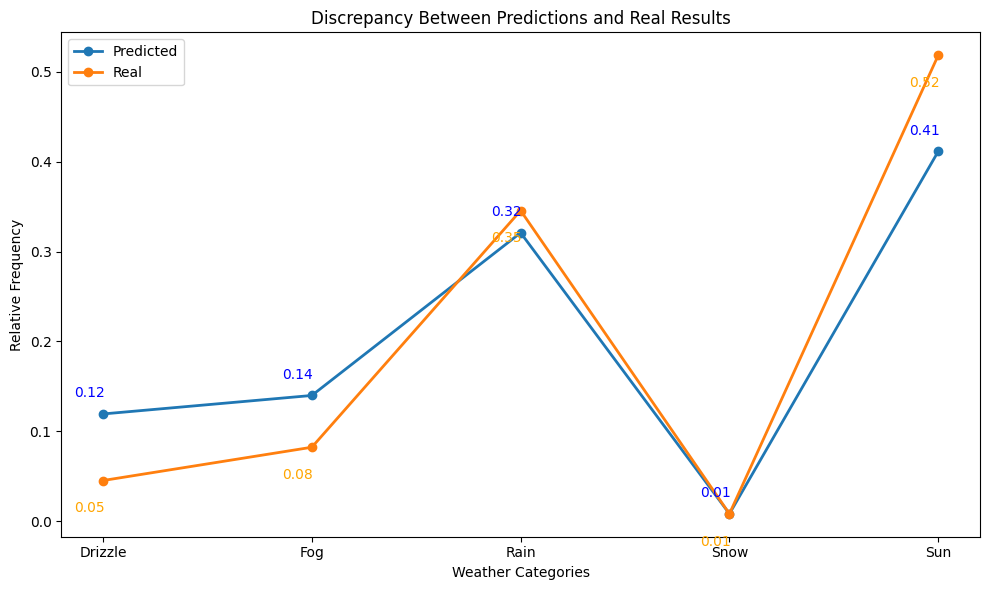

In [28]:
# calculate the distribution of predicted and real labels
y_pred_counts = pd.Series(y_pred_test).value_counts(normalize=True)  # Relative frequencies of predicted labels
y_real_counts = pd.Series(y_test).value_counts(normalize=True)       # Relative frequencies of actual labels

# align the categories based on the mapping
categories = list(weather_mapping.values())  # List of weather categories in human-readable form
predicted_distribution = [y_pred_counts.get(i, 0) for i in range(len(weather_mapping))]  # Predicted distribution
real_distribution = [y_real_counts.get(i, 0) for i in range(len(weather_mapping))]       # Real distribution

# create a line graph to visualize discrepancies
fig, ax = plt.subplots(figsize=(10, 6))

# line graph for predicted distribution
ax.plot(categories, predicted_distribution, marker='o', label='Predicted', linestyle='-', linewidth=2)

# line graph for real distribution
ax.plot(categories, real_distribution, marker='o', label='Real', linestyle='-', linewidth=2)

# add labels and title to the graph
ax.set_xlabel('Weather Categories')  
ax.set_ylabel('Relative Frequency')  
ax.set_title('Discrepancy Between Predictions and Real Results')  
ax.legend()  

# display relative frequency values above each point in the graph
for i, category in enumerate(categories):
    # annotate the predicted distribution
    ax.annotate(f'{predicted_distribution[i]:.2f}',
                xy=(category, predicted_distribution[i]),
                xytext=(-10, 10),  # offset for better readability
                textcoords="offset points",
                ha='center', va='bottom', color='blue')
    # annotate the real distribution
    ax.annotate(f'{real_distribution[i]:.2f}',
                xy=(category, real_distribution[i]),
                xytext=(-10, -15),  # offset for better readability
                textcoords="offset points",
                ha='center', va='top', color='orange')

plt.tight_layout()
plt.show()
